In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import pydicom

# Set the directories for test and training data
TEST_DIR = "/home/fgj4kw/Downloads/stage_2_test_images"
TRAIN_DIR = "/home/fgj4kw/Downloads/stage_2_train_images"

# Get all the DICOM image paths from the directories
s2_test_images = glob(os.path.join(TEST_DIR, "**", "*.dcm"), recursive=True)
s2_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.dcm"), recursive=True)

# Function to preprocess the dataset
def preprocess_full_dataset(image_paths, target_size=(224, 224)):
    images = []
    for path in tqdm(image_paths, desc="Preprocessing dataset"):
        try:
            ds = pydicom.dcmread(path)  # Read the DICOM file
            img = ds.pixel_array  # Get the pixel array (image)
            img_resized = cv2.resize(img, target_size)  # Resize the image to 224x224
            img_normalized = img_resized.astype(np.float32) / np.max(img_resized)  # Normalize to [0, 1]
            images.append(img_normalized)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(images)

# Preprocess the datasets
X_train_full = preprocess_full_dataset(s2_train_images)
X_test_full = preprocess_full_dataset(s2_test_images)

# Add a channel dimension for grayscale images (from (224, 224) to (224, 224, 1))
X_train_full = np.expand_dims(X_train_full, axis=-1)
X_test_full = np.expand_dims(X_test_full, axis=-1)

# Check the shape of the preprocessed data
print(f"Training data shape: {X_train_full.shape}")
print(f"Test data shape: {X_test_full.shape}")


Preprocessing dataset: 100%|██████████| 3000/3000 [01:57<00:00, 25.58it/s]


Training data shape: (26684, 224, 224, 1)
Test data shape: (3000, 224, 224, 1)


In [2]:
import pandas as pd

# Load the CSV file into a DataFrame
labels_df = pd.read_csv("/home/fgj4kw/Downloads/stage_2_detailed_class_info.csv")

# Create a dictionary to map patientId to class labels (3 categories)
labels_dict = {}
label_mapping = {
    "Normal": 0,                   # 0 for normal
    "No Lung Opacity / Not Normal": 2,  # 2 for other abnormalities (non-pneumonia)
    "Lung Opacity": 1              # 1 for pneumonia (lung opacity)
}

# Populate the dictionary with patientId and corresponding label
for _, row in labels_df.iterrows():
    labels_dict[row['patientId']] = label_mapping.get(row['class'], -1)  # Use -1 for any unknown class

# Check the first few labels to confirm correct mapping
print("Sample labels dictionary:", dict(list(labels_dict.items())[:5]))



Sample labels dictionary: {'0004cfab-14fd-4e49-80ba-63a80b6bddd6': 2, '00313ee0-9eaa-42f4-b0ab-c148ed3241cd': 2, '00322d4d-1c29-4943-afc9-b6754be640eb': 2, '003d8fa0-6bf1-40ed-b54c-ac657f8495c5': 0, '00436515-870c-4b36-a041-de91049b9ab4': 1}


In [7]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os

class DICOMDataGenerator(Sequence):
    def __init__(self, image_paths, images, labels_dict, batch_size=32, shuffle=True):
        """
        Initialization of the generator.
        :param image_paths: List of image file paths (for extracting patient IDs)
        :param images: List of preprocessed image arrays (X_train_full or X_test_full)
        :param labels_dict: Dictionary of patient IDs to labels
        :param batch_size: Number of samples per batch
        :param shuffle: Whether to shuffle the data after every epoch
        """
        self.image_paths = image_paths  # List of image file paths (for patient IDs)
        self.images = images  # List of preprocessed image arrays (X_train_full or X_test_full)
        self.labels_dict = labels_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))  # Keeps track of image indices

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data.
        :param index: Index of the batch
        """
        # Get the batch of image indices and their corresponding labels
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[i] for i in batch_indexes]  # Get images for the batch
        batch_labels = self.__get_labels(batch_indexes)  # Get corresponding labels based on indices
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        """
        Shuffles the data after each epoch, if needed.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __get_labels(self, batch_indexes):
        """
        Generates the corresponding labels for the batch of images (one-hot encoded).
        :param batch_indexes: List of indexes in the current batch
        :return: List of one-hot encoded labels
        """
        labels = []
        for idx in batch_indexes:
            # Use the index to get the patient ID (from image_paths, which contain the filenames)
            patient_id = os.path.basename(self.image_paths[idx]).split('.')[0]  # Extract patient ID from filename

            label = self.labels_dict.get(patient_id, -1)  # Fetch label from the dictionary
            # Convert label to one-hot encoding
            one_hot = [0, 0, 0]  # Initialize one-hot vector for 3 classes
            if label != -1:  # Ensure we got a valid label
                one_hot[label] = 1
            labels.append(one_hot)
        return labels


In [8]:
# Initialize the train and test generators using the preprocessed images (X_train_full and X_test_full)
train_generator = DICOMDataGenerator(
    s2_train_images, X_train_full, labels_dict, batch_size=32, shuffle=True
)

test_generator = DICOMDataGenerator(
    s2_test_images, X_test_full, labels_dict, batch_size=32, shuffle=False
)

In [9]:
# Print the first batch of images and their corresponding labels
images, labels = train_generator[0]
print("First batch of images:", images)
print("First batch of labels:", labels)

First batch of images: [[[[0.25506073]
   [0.07692308]
   [0.01214575]
   ...
   [0.04048583]
   [0.08502024]
   [0.19433199]]

  [[0.23481782]
   [0.07287449]
   [0.01214575]
   ...
   [0.00404858]
   [0.01214575]
   [0.048583  ]]

  [[0.2388664 ]
   [0.06882591]
   [0.00809717]
   ...
   [0.00404858]
   [0.00404858]
   [0.01619433]]

  ...

  [[0.01214575]
   [0.00809717]
   [0.00809717]
   ...
   [0.00404858]
   [0.09716599]
   [0.34817815]]

  [[0.01619433]
   [0.00809717]
   [0.00809717]
   ...
   [0.00809717]
   [0.10526316]
   [0.3562753 ]]

  [[0.0242915 ]
   [0.01214575]
   [0.01214575]
   ...
   [0.01214575]
   [0.10526316]
   [0.36437246]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.0669456 ]
   [0.07531381]
   [0.07531381]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.0669456 ]
   [0.0669456 ]
   [0.0669456 ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.06276151]
   [0.0669456 ]
   [0.0669456 ]]

  ...

  [[0.        ]


In [10]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for binary classification
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(list(labels_dict.values())),
    y=list(labels_dict.values())
)

# Create a dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Display the class weights dictionary
print("Class weight dictionary:", class_weight_dict)


Class weight dictionary: {0: 1.004933529168079, 1: 1.4794854734974496, 2: 0.7524462115444266}


In [11]:
from tensorflow.keras import models, layers


def build_classification_model(input_shape=(224, 224, 1)):  # Grayscale input (1 channel)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(3, activation='softmax')  # 3 output neurons for 3 classes (using softmax)
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
segmentation_model = build_classification_model(input_shape=(224, 224, 1))

# Model summary
segmentation_model.summary()


/home/fgj4kw/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-21 01:42:54.822603: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       559,875 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,691 (2.21 MB)

 Trainable params: 578,691 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = segmentation_model.fit(
    train_generator, 
    epochs=5, 
    validation_data=test_generator)

Epoch 1/5


/home/fgj4kw/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


833/833 ━━━━━━━━━━━━━━━━━━━━ 247s 296ms/step - accuracy: 0.5067 - loss: 1.0482 - val_accuracy: 0.3246 - val_loss: 0.0000e+00
Epoch 2/5
833/833 ━━━━━━━━━━━━━━━━━━━━ 247s 297ms/step - accuracy: 0.5971 - loss: 0.8442 - val_accuracy: 0.3397 - val_loss: 0.0000e+00
Epoch 3/5
833/833 ━━━━━━━━━━━━━━━━━━━━ 246s 296ms/step - accuracy: 0.6264 - loss: 0.8076 - val_accuracy: 0.3239 - val_loss: 0.0000e+00
Epoch 4/5
833/833 ━━━━━━━━━━━━━━━━━━━━ 246s 295ms/step - accuracy: 0.6612 - loss: 0.7528 - val_accuracy: 0.3105 - val_loss: 0.0000e+00
Epoch 5/5
833/833 ━━━━━━━━━━━━━━━━━━━━ 249s 299ms/step - accuracy: 0.7080 - loss: 0.6732 - val_accuracy: 0.2144 - val_loss: 0.0000e+00


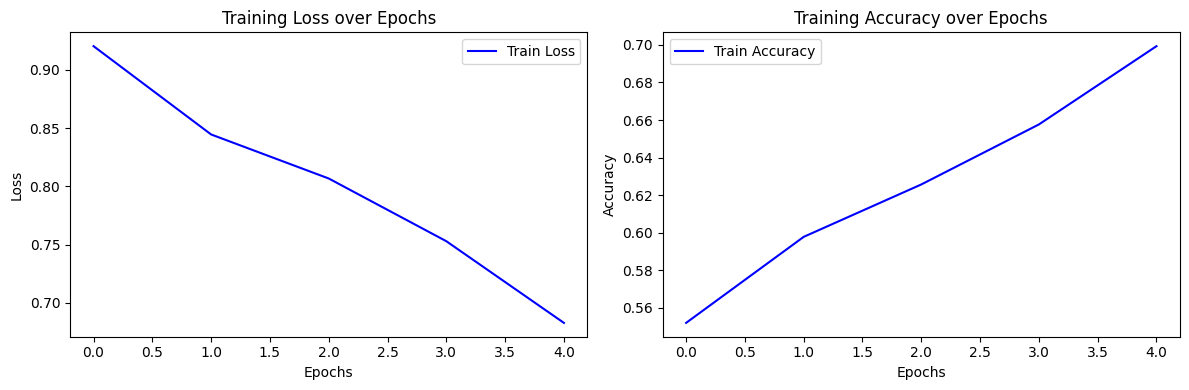

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Left: Training Loss Only
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Right: Training Accuracy Only
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy", color="blue")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


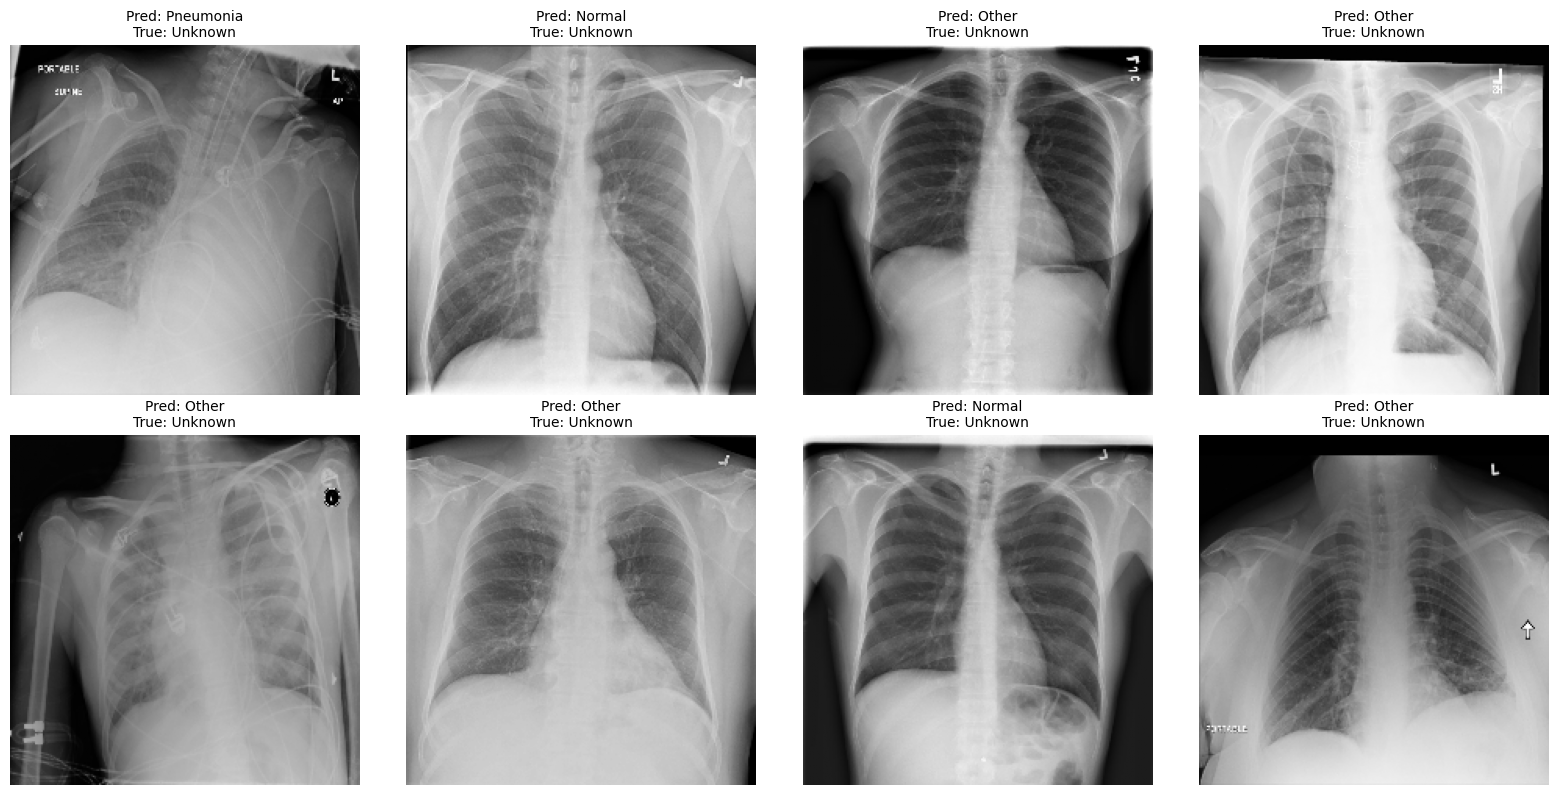

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the generator
imgs, labels = next(iter(test_generator))

# Predict class probabilities
pred_probs = segmentation_model.predict(imgs)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(labels, axis=1)

class_names = ["Normal", "Pneumonia", "Other"]

plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(imgs[i, :, :, 0], cmap="gray")
    true_label = true_classes[i]
    pred_label = pred_classes[i]

    true_str = class_names[true_label] if np.sum(labels[i]) != 0 else "Unknown"
    plt.title(f"Pred: {class_names[pred_label]}\nTrue: {true_str}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
